In [1]:
import math
import numpy as np
from matplotlib import pyplot as pp
from collections import namedtuple
import random
from statsmodels.tsa.stattools import acf
%matplotlib inline

# Purpose

The purpose is to test the "memory" of different reservoir schemes.

This will be kept very simple --- we won't be dealing with weights, etc. Everything will have a weight of 1.

## Data Generators

We will have two data generators. The first will simply generate a random stream of independent values within a certain range. The second will also have a uniform distribution, but will tend to be much "streakier".

In [2]:
def gen_independent(max_value, max_samples):
    for _ in range(max_samples):
        yield random.randint(0, max_value)
        
def gen_streaky(max_value, max_samples, switch_prob):
    state = True
    split = max_value // 2
    
    for _ in range(max_samples):
        if random.random() < switch_prob:
            state = not state
        if state:
            yield random.randint(0, split)
        else:
            yield random.randint(split+1, max_value)

## Reservoir Entry

This is a simple structure to represent a reservoir entry.

In [3]:
Entry = namedtuple('Entry', 'value weight')

## Simple Resampling

This scheme simply does resampling every time the reservoir is full.

In [4]:
class Reservoir(object):
    def __init__(self, max_value):
        self.max_value = max_value
        self.target_size = 50
        self.max_size = 100
        self.contents = []

    def insert(self, entry):
        assert entry.value >= 0
        assert entry.value <= self.max_value
        self.contents.append(entry)
        
        if len(self.contents) >= self.max_size:
            self.resample()
    
    def compute_stats(self):
        return np.histogram([x.value for x in self.contents],
                            range=(0, self.max_value),
                            bins=self.max_value+1,
                            density=True)[0]
    
    def resample(self):
        new_contents = [random.choice(self.contents) for _ in range(self.target_size)]
        #new_contents = random.sample(self.contents, self.target_size)
        self.contents = new_contents

## Slowed Growth Resampling

This scheme slows down adding new structures as it resamples to remove old ones. This should result in a reservoir that converges to a Boltzmann distribution.

In [5]:
class SlowReservoir(object):
    def __init__(self, max_value):
        self.max_value = max_value
        self.target_size = 50
        self.max_size = 100
        self.contents = []
        self.insert_factor = 1.0

    def insert(self, entry):
        assert entry.value >= 0
        assert entry.value <= self.max_value
        
        if random.random() < self.insert_factor:
            self.contents.append(entry)
        
        if len(self.contents) >= self.max_size:
            self.resample()
    
    def compute_stats(self):
        return np.histogram([x.value for x in self.contents],
                            range=(0, self.max_value),
                            bins=self.max_value+1,
                            density=True)[0]
    
    def resample(self):
        n1 = float(len(self.contents))
        n2 = float(self.target_size)
        self.insert_factor = self.insert_factor * n2 / n1
        
        new_contents = [random.choice(self.contents) for _ in range(self.target_size)]
        #new_contents = random.sample(self.contents, self.target_size)
        self.contents = new_contents

## Test Function

This function will test a particular combination of generator and reservoir.

In [6]:
def do_test(n_samples, max_value, generator, reservoir_class):
    r = reservoir_class(max_value)
    results = np.zeros((max_value+1, n_samples))
    for i in range(n_samples):
        sample = next(generator)
        r.insert(Entry(sample, 1.0))
        results[:, i] = r.compute_stats()
    return results

## Simple resampling without correlation

In [7]:
results1 = do_test(50000, 20, gen_independent(20, 50000), Reservoir)

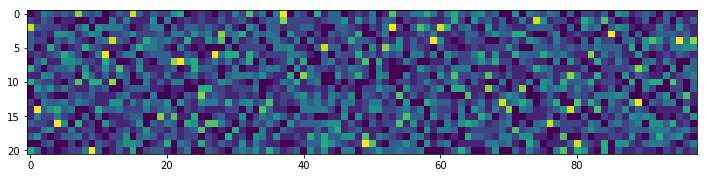

In [8]:
pp.figure(figsize=(12,12))
pp.imshow(results1[:, 1000::500], vmin=0, vmax=0.2);

This is behaving as expected. The distribution changes over time depending on what has most recently been sampled.

The graph below verifies that the time average of the reservoir has the expected uniform distribution.

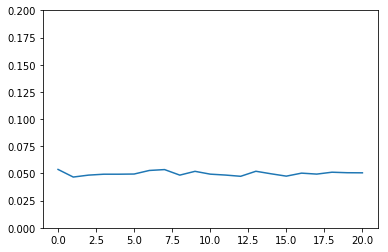

In [9]:
pp.plot(np.mean(results1, axis=1))
pp.ylim(0, 0.2);

The graphs above don't really show the resampling, so let's look at a shorter time period.

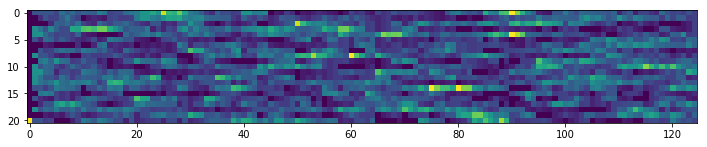

In [30]:
pp.figure(figsize=(12,12))
pp.imshow(results1[:, :2500:20], vmin=0, vmax=0.2);

## Simple resampling with correlation

In [11]:
results2 = do_test(50000, 20, gen_streaky(20, 50000, 0.005), Reservoir)

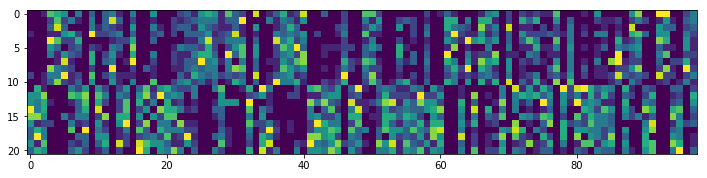

In [12]:
pp.figure(figsize=(12,12))
pp.imshow(results2[:, 1000::500], vmin=0, vmax=0.2);

This is also behaving as expected. There are large shifts in the resrvoir over time due to the finite "memory" effect. The reservoir almost never has the correct distribution at any instant in time. However, the graph below shows that the average distribution of the reservoir is correct (the deviation from uniform is simply due to insufficient sampling).

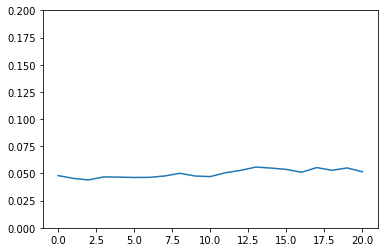

In [13]:
pp.plot(np.mean(results2, axis=1))
pp.ylim(0, 0.2);

The graphs above don't really show the resampling, so let's look at a shorter time period.

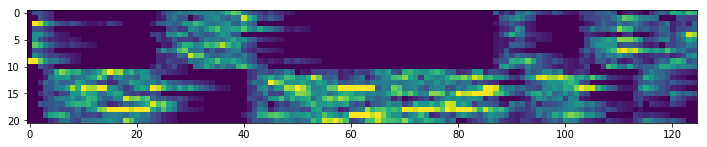

In [31]:
pp.figure(figsize=(12,12))
pp.imshow(results2[:, :2500:20], vmin=0, vmax=0.2);

## Slow resampling without correlation

In [15]:
results3 = do_test(50000, 20, gen_independent(20, 50000), SlowReservoir)

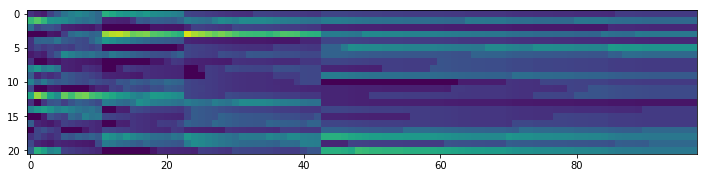

In [16]:
pp.figure(figsize=(12,12))
pp.imshow(results3[:, 1000::500], vmin=0, vmax=0.2)

This is behaving as expected. The distribution rapidly converges towards the expected uniform distribution.

The graph below shows the final distribution at the end. This has the expected uniform distribution, but seems to have a higher variance than above.

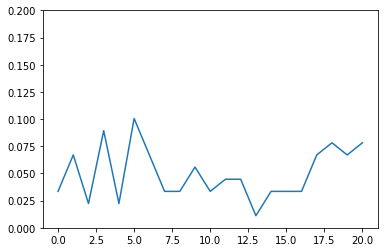

In [17]:
pp.plot(results3[:, -1])
pp.ylim(0, 0.2);

The graphs above don't really show the resampling, so let's look at a shorter time period.

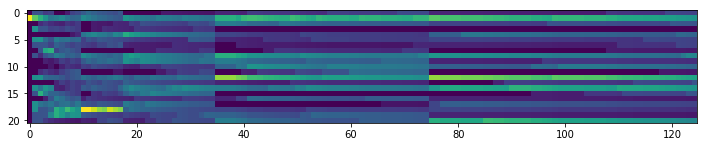

In [32]:
pp.figure(figsize=(12,12))
pp.imshow(results3[:, :2500:20], vmin=0, vmax=0.2);

## Slow resampling with correlation

In [19]:
results4 = do_test(50000, 20, gen_streaky(20, 50000, 0.005), SlowReservoir)

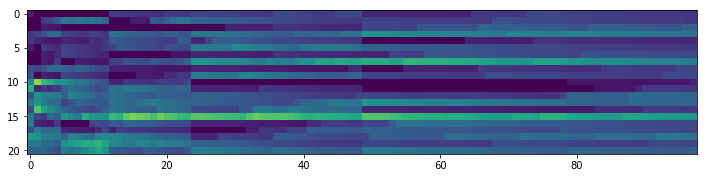

In [20]:
pp.figure(figsize=(12,12))
pp.imshow(results4[:, 1000::500], vmin=0, vmax=0.2)

Again, this is behaving as expected, converging towards a uniform distribution.

The graph below shows the final distribution.

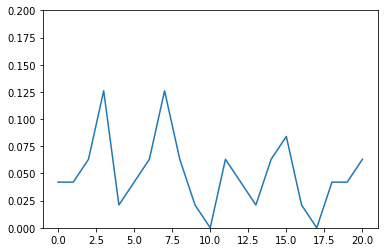

In [21]:
pp.plot(results4[:, -1])
pp.ylim(0, 0.2);

The graphs above don't really show the resampling, so let's look at a shorter time period.

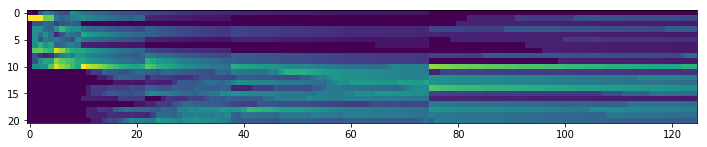

In [33]:
pp.figure(figsize=(12,12))
pp.imshow(results4[:, :2500:20], vmin=0, vmax=0.2);

## Comparison of final distributions

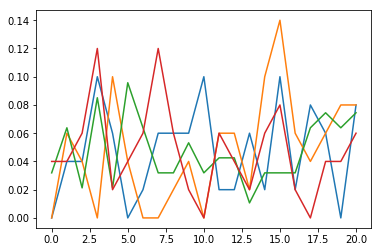

In [34]:
pp.plot(results1[:, -1] / np.sum(results1[:, -1]))
pp.plot(results2[:, -1] / np.sum(results2[:, -1]))
pp.plot(results3[:, -1] / np.sum(results3[:, -1]))
pp.plot(results4[:, -1] / np.sum(results4[:, -1]));

This clearly shows the issue with the "forgetful" versions of the reservoir. In both cases the instantaneous distribution of the reservoir varies quite a lot, particularly when the sampling is correlated.

## Assessment of sampling quality

It's not clear how to translate the previous graphs into something that actually tells us about sampling quality. Instead, let's create a process that samples a single value from the reservoir at each step. The more uncorrelated this process is, the better sampling is.

In [24]:
def sample(res):
    probs = res / np.sum(res, axis=0)
    N = res.shape[1]
    output = np.zeros(N)
    for i in range(N):
        output[i] = np.random.choice(21, p=probs[:, i])
    return output

In [25]:
trace1 = sample(results1)
trace2 = sample(results2)
trace3 = sample(results3)
trace4 = sample(results4)

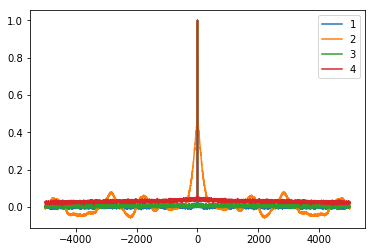

In [26]:
pp.acorr(trace1 - 10.0, usevlines=False, maxlags=5000, linestyle='-', marker='', label='1');
pp.acorr(trace2 - 10.0, usevlines=False, maxlags=5000, linestyle='-', marker='', label='2');
pp.acorr(trace3 - 10.0, usevlines=False, maxlags=5000, linestyle='-', marker='', label='3');
pp.acorr(trace4 - 10.0, usevlines=False, maxlags=5000, linestyle='-', marker='', label='4');
pp.legend();

In [27]:
print np.mean(trace1)
print np.mean(trace2)
print np.mean(trace3)
print np.mean(trace4)

10.0
10.33606
10.18992
10.87252
